In [4]:
import os
import re
import numpy as np

# # ================================================================================
# def read_flameSpeedLog(path):
#     data = {}

#     for root, dirs, files in os.walk(path):
#         for file in files:
#             if 'flameSpeed' in file:
#                 temp = []
#                 start_reading = False
#                 with open(os.path.join(root, file), 'r') as f:
#                     for line in f:
#                         if line.strip() == '':
#                             continue
#                         if 'Create time' in line:
#                             start_reading = True
#                             continue
#                         if not start_reading:
#                             continue
#                         words = line.split()
#                         if words[0] == 'Time' or words[0] == 'flamePropagationSpeed' or words[0] == 'flameSpeed':
#                             temp.append(float(words[2]))
#                             if len(temp) == 3:
#                                 dir_name = os.path.basename(root)
#                                 if 'data' in dir_name:
#                                     dir_name = dir_name.split('data_', 1)[-1]
#                                 if 'result' in dir_name:
#                                     dir_name = file.split('validation_', 1)[-1]
#                                     dir_name = dir_name.split('_log', 1)[0]
#                                 if dir_name not in data:
#                                     data[dir_name] = []
#                                 data[dir_name].append(temp)
#                                 temp = []

#     for key in data:
#         data[key] = np.array(data[key])
        
#     return data
# # ================================================================================

# pattern = r"[-+]?\d+(?:\.\d+)?"

# # 使用findall函数提取所有匹配的数字
# numbers = re.findall(pattern, text)

# # ================================================================================
# def check_time(arr1, arr2):
#     time_arr1 = arr1[:, 0]
#     time_arr2 = arr2[:, 0]
    
#     if len(time_arr1) != len(time_arr2):
#         print('Lengths of the time arrays are different.')
#         return False
#     else:
#         if np.array_equal(time_arr1, time_arr2):
#             print('Time arrays are equal.')
#             return True
#         else:
#             print('Time arrays are not equal.')
#             return False
# # ================================================================================

# # ================================================================================
# def flame_speed_extraction(arr):
#     for i in range(len(arr) - 1, 0, -1):
#         if arr[i, 1] < 1e-6 and abs((arr[i, 2] - arr[i-1, 2]) / arr[i-1, 2]) < 0.01:
#             return arr[i, 0], arr[i, 2], i
#     return None, None, None
# # ================================================================================


# # ================================================================================
# # ================================================================================


# cvode_data = read_flameSpeedLog('/home/xk/Uni/4_dnn/1_NH3_CH4/1_CurrentWork/1_resampleWithFlameSpeed/2_sampling/sampling')
# dnn_data = read_flameSpeedLog('/home/xk/Uni/4_dnn/1_NH3_CH4/1_CurrentWork/1_resampleWithFlameSpeed/4_validation/3_oneDresults')

# print(cvode_data)
# print(dnn_data)

# for key in cvode_data.keys():
#     print(key)
# # for key in dnn_data.keys():
# #     if key in cvode_data.keys():
# #         print()
# #         print(key)
# #         check_time(cvode_data[key], dnn_data[key])
# #         selected_time, flame_speed, index = flame_speed_extraction(dnn_data[key])
# #         time_cvode, flame_speed_cvode = cvode_data[key][index,0], cvode_data[key][index, 2]
# #         print('Selected time:', time_cvode, selected_time)
# #         print('Flame speed of cvode:', flame_speed_cvode)
# #         print('Flame speed:', flame_speed)
# #         print(cvode_data[key], dnn_data[key])

In [27]:
cvode_data_path = '/home/xk/Uni/4_dnn/1_NH3_CH4/1_CurrentWork/1_resampleWithFlameSpeed/2_sampling/sampling'
dnn_data_path = '/home/xk/Uni/4_dnn/1_NH3_CH4/1_CurrentWork/1_resampleWithFlameSpeed/4_validation/3_oneDresults'

from pathlib import Path

def find_log_files(root_dir):
    root_dir = Path(root_dir)
    log_files = []
    tags = []
    for file in root_dir.rglob('log.flameSpeed'):
        split_strings = file.parent.name.split('_')
        fuel_comp, equivalence_ratio_string = split_strings[-2], split_strings[-1]
        
        match = re.search(r'\d+', equivalence_ratio_string)
        if match: 
            equivalence_ratio = float(match.group())/1000 
        else: 
            equivalence_ratio = None
        
        log_files.append([file, fuel_comp, equivalence_ratio])
    return log_files

def read_log_file(log_file):
    with open(log_file, 'r') as file:
        lines = file.readlines()

    start_index = None
    end_index = None

    for i, line in enumerate(lines):
        if 'Create mesh for time' in line:
            start_index = i + 1
        elif 'ExecutionTime' in line:
            end_index = i
            break

    content = lines[start_index:end_index]

    numbers = []

    for line in content:
        # print(line.strip())
        
        pattern = r'[-+]?\d*[\.]?\d+[eE]?[-+]?\d*'
        match = re.search(pattern, line)
        if match:
            numbers.append(float(match.group()))

    # for number in numbers:
    #     print(number)
        
    assert len(numbers) % 5 == 0, "The length of numbers must be a multiple of 5"

    numbers_array = np.array(numbers)
    numbers_array = numbers_array.reshape(-1, 5)[1:,:][::-1,:]

    # print(numbers_array)
    return numbers_array

def data_extract(array):
    
    def relative_error_check(num1, num2):
        relative_error = abs(num1 - num2) / max(abs(num1), abs(num2))
        return relative_error < 0.001
    
    for i in range(array.shape[0] - 1):  # 遍历除最后一行外的每一行
        if relative_error_check(array[i, 2], array[i+1, 2]) \
            and relative_error_check(array[i, 4], array[i+1, 4]) \
            and abs(array[i, 3]) < 1e-6:
            return array[i, :]
    return array[0, :]

log_files_cvode = find_log_files(cvode_data_path)
log_files_dnn = find_log_files(dnn_data_path)

for j, log_file in enumerate(log_files_cvode):
    log_file.append(data_extract(read_log_file(log_file[0])))
    print(log_file)

for j, log_file in enumerate(log_files_dnn):
    log_file.append(data_extract(read_log_file(log_file[0])))
    print(log_file)

# print()

# for j, log_file in enumerate(log_files_dnn):
#     data = data_extract(read_log_file(log_file[0]))
#     # print(data, log_file)
#     print(data)
    
# print(log_data)

[PosixPath('/home/xk/Uni/4_dnn/1_NH3_CH4/1_CurrentWork/1_resampleWithFlameSpeed/2_sampling/sampling/4_data_blr0200_eqr0800/log.flameSpeed'), 'blr0200', 0.8, array([0.01691   , 0.00070965, 0.0174713 , 0.        , 0.211245  ])]
[PosixPath('/home/xk/Uni/4_dnn/1_NH3_CH4/1_CurrentWork/1_resampleWithFlameSpeed/2_sampling/sampling/7_data_blr0400_eqr0800/log.flameSpeed'), 'blr0400', 0.8, array([0.02691  , 0.0008725, 0.0210683, 0.       , 0.164985 ])]
[PosixPath('/home/xk/Uni/4_dnn/1_NH3_CH4/1_CurrentWork/1_resampleWithFlameSpeed/2_sampling/sampling/9_data_blr0400_eqr1200/log.flameSpeed'), 'blr0400', 1.2, array([0.02521   , 0.00090759, 0.0217303 , 0.        , 0.179766  ])]
[PosixPath('/home/xk/Uni/4_dnn/1_NH3_CH4/1_CurrentWork/1_resampleWithFlameSpeed/2_sampling/sampling/2_data_blr0000_eqr1000/log.flameSpeed'), 'blr0000', 1.0, array([0.00651   , 0.00049408, 0.0118594 , 0.        , 0.374677  ])]
[PosixPath('/home/xk/Uni/4_dnn/1_NH3_CH4/1_CurrentWork/1_resampleWithFlameSpeed/2_sampling/sampling/3

In [28]:
grouped_lists = {}
for i, log_file in enumerate(log_files_cvode):
    key = log_file[1]
    if key not in grouped_lists:
        grouped_lists[key] = []
    grouped_lists[key].append(log_file)
    
grouped_lists_dnn = {}
for i, log_file in enumerate(log_files_dnn):
    key = log_file[1]
    if key not in grouped_lists_dnn:
        grouped_lists_dnn[key] = []
    grouped_lists_dnn[key].append(log_file)

# for key, group in grouped_lists.items():
#     print(f"Key: {key}")
#     print(group)
#     for log_file in group:
#         print(log_file)
#     print()

Text(0, 0.5, 'Flame Location')

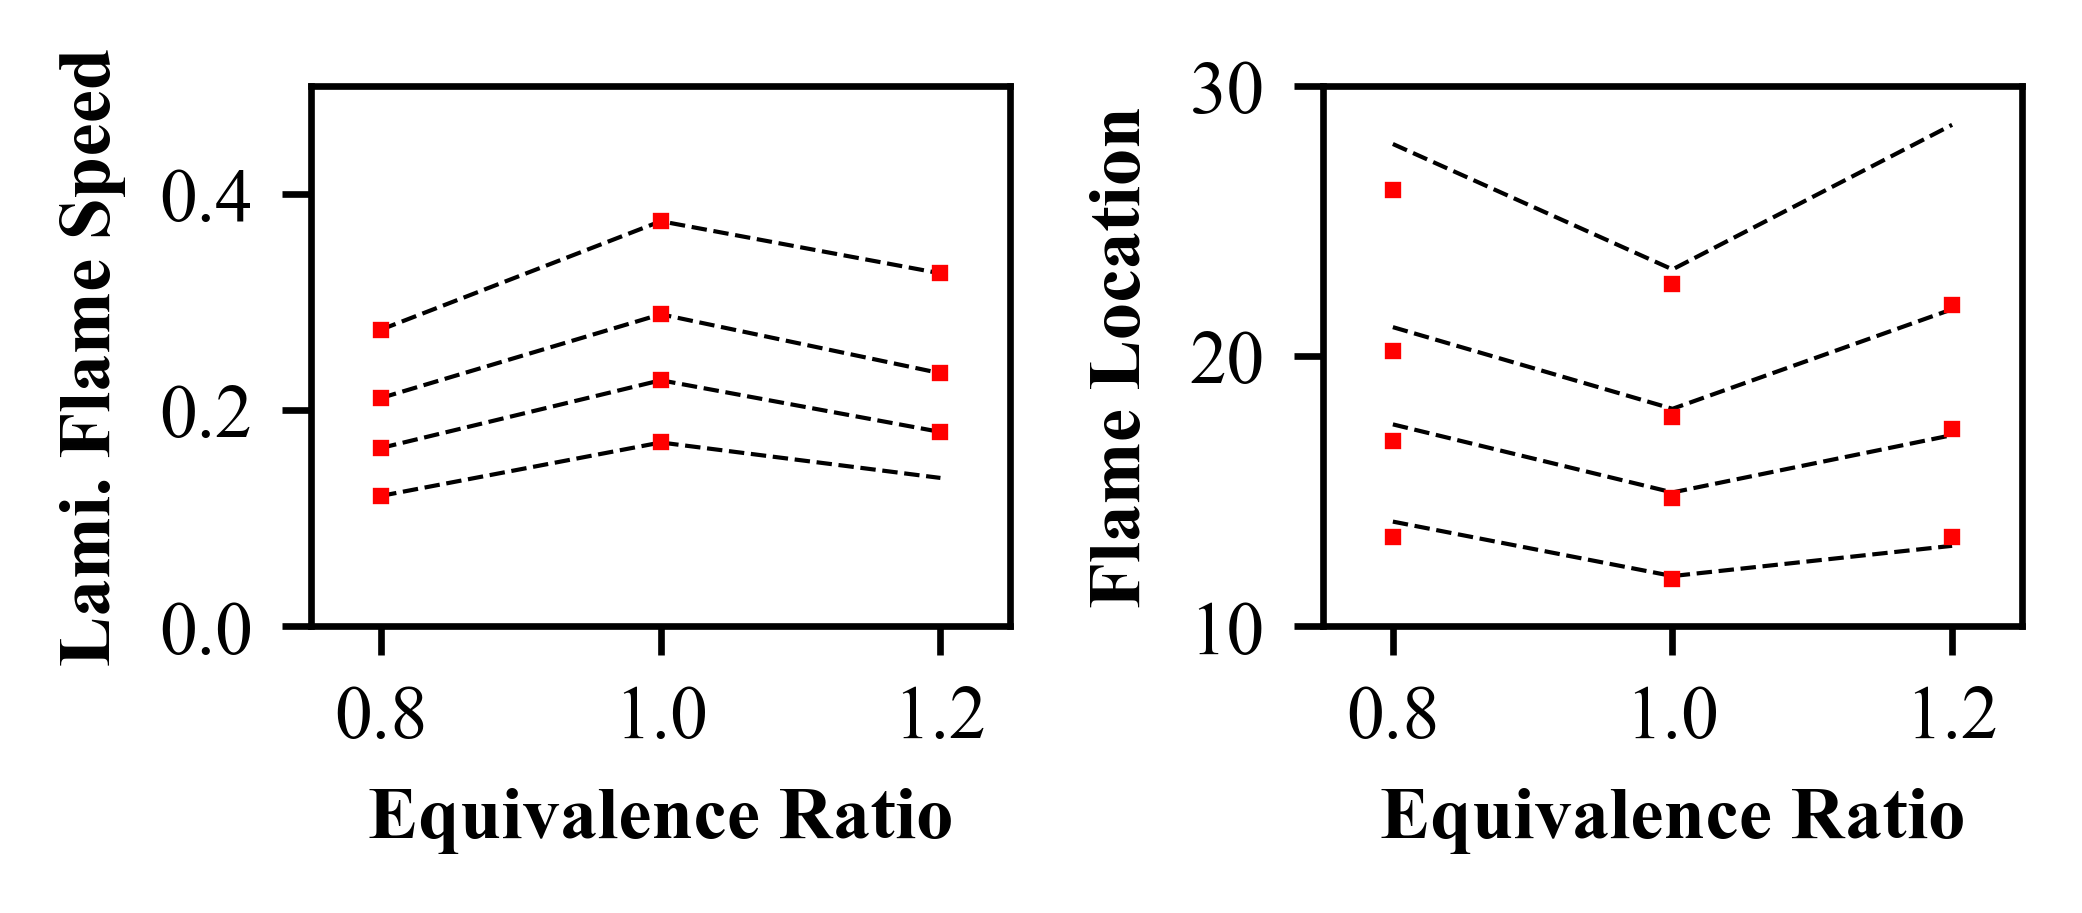

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 9

fig, axes = plt.subplots(1, 2, figsize=(3.54, 3.54*0.45), dpi=600, layout='tight')

for key, group in grouped_lists.items():
    group.sort(key=lambda x: x[2])
    x = [log_file[2] for log_file in group]
    y = [log_file[3][4] for log_file in group]
    axes[0].plot(x,y,'k--',lw=0.5)
    
for key, group in grouped_lists_dnn.items():
    group.sort(key=lambda x: x[2])
    x = [log_file[2] for log_file in group]
    y = [log_file[3][4] for log_file in group]
    axes[0].plot(x,y,'rs',markersize=1)

for key, group in grouped_lists.items():
    group.sort(key=lambda x: x[2])
    x = [log_file[2] for log_file in group]
    y = [log_file[3][2]*1000 for log_file in group]
    axes[1].plot(x,y,'k--',lw=0.5)
    
for key, group in grouped_lists_dnn.items():
    group.sort(key=lambda x: x[2])
    x = [log_file[2] for log_file in group]
    y = [log_file[3][2]*1000 for log_file in group]
    axes[1].plot(x,y,'rs',markersize=1)

axes[0].set_xlim(0.75, 1.25)
axes[0].set_ylim(0, 0.5)

axes[1].set_xlim(0.75, 1.25)
axes[1].set_ylim(10, 30)

# axes[0].set_title("Premixed Turbulent Combustion\nRegime Diagram",fontweight='bold')
axes[0].set_xlabel("Equivalence Ratio",fontweight='bold')
axes[0].set_ylabel("Lami. Flame Speed",fontweight='bold')

axes[1].set_xlabel("Equivalence Ratio",fontweight='bold')
axes[1].set_ylabel("Flame Location",fontweight='bold')


In [11]:
from tabulate import tabulate, SEPARATING_LINE
tabulate.PRESERVE_WHITESPACE = True

table = []
headers = [
    'Fuel Comp.',
    'Equi. Ratio',
    'flameLocation_CVODE',
    'flameLocation_DNN',
    'flameLocation_ERR',
    'flameSpeed_CVODE',
    'flameSpeed_DNN',
    'flameSpeed_ERR'
]

for i, case in enumerate(case_list):
    table.append([
        case.fuel_composition,
        f"{case.equivalence_ratio:.1f}",
        f"{case.laminar_flame_speed*1000:.2f}",
        f"{turbulent_velocity:.0f}",
        f"{y[i]:.2f}",
        f"{case.laminar_flame_thickness*1000:.2f}",
        f"{domain_sizes[i]*1000:.0f}",
        f"{turbulent_length_scales[i]*1000:.2f}",
        f"{x[i]:.2f}",
        f"{Re[i]:.2f}",
        f"{Ka[i]:.2f}",
        f"{Da[i]:.2f}"
    ])

table_align_fmt = ("left", "right", "right", "right", "right", "right", 
                   "right", "right", "right", "right", "right", "right")
print(tabulate(table, headers, tablefmt="simple", colalign=table_align_fmt, disable_numparse=True))